In [1]:
import os	
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import keras
from keras import layers

# Data preparation

## Loading the dataset

In [2]:
# Path to the dataset
DATA_DIR = 'data/train'

In [3]:
# Load the dataset
images = []
labels = []

dir = os.listdir(DATA_DIR)
num_samples = len(dir)

# Loop through each folder in the dataset
for i, folder in enumerate(os.listdir(DATA_DIR)):
    if((i + 1) % 5 == 0):
        print(f"{i + 1}/{num_samples}")
    folder_path = os.path.join(DATA_DIR, folder)
    if os.path.isdir(folder_path):
        # Extract the character label from the folder name (e.g., Sample001 -> '001')
        label = folder[6:]  # Assuming 'SampleXXX' format

        # Loop through each image in the folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            # Read the image in grayscale
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28, 28))

            # Append image and label to the lists
            images.append(img)
            labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

5/62
10/62
15/62
20/62
25/62
30/62
35/62
40/62
45/62
50/62
55/62
60/62


In [4]:
# Reshape the images to add a channel dimension (for grayscale images)
images = images.reshape(-1, 28, 28, 1)

# Normalize pixel values to the range [0, 1]
X = images / 255.0

In [5]:
# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

## Check

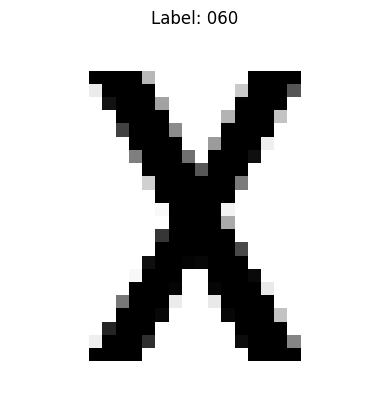

In [6]:
# Select an image to visualize (e.g., the first image in the dataset)
image_index = 0

# Extract the corresponding image from the dataset
image_to_show = X[image_index].squeeze()

plt.imshow(image_to_show, cmap='gray')
plt.title(f"Label: {label_encoder.inverse_transform([y[image_index]])[0]}")
plt.axis('off')  # Turn off axis
plt.show()

# Parameter Tuning

## Bayesian Optimization
using Keras tuner

In [7]:
from keras_tuner import HyperModel, Objective
import tensorflow as tf
from keras_tuner.tuners import BayesianOptimization

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
# Create the keras tuner model.
class CNNHyperModel(HyperModel):
    
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.InputLayer(input_shape=(28, 28, 1)))

        # First convolutional layer
        model.add(layers.Conv2D(
            filters=64,
            kernel_size=(3, 3),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Second convolutional layer
        model.add(layers.Conv2D(
            filters=hp.Int('filters_2', min_value=96, max_value=224),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Flatten and Dense layer
        model.add(layers.Flatten())
        model.add(layers.Dense(
            units=hp.Int('dense_units', min_value=256, max_value=512),
            activation='relu'
        ))

        model.add(layers.Dropout(
            rate=hp.Float('dropout_rate', min_value=0.15, max_value=0.3)
        ))

        # Output layer
        model.add(layers.Dense(62, activation='softmax'))  # Assuming 62 classes for character classification

        # Compile the model
        optimizer_instance = keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        )

        # Compile the model
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

class MyTuner(BayesianOptimization):
    def __init__(self, *args, **kwargs):
        super(MyTuner, self).__init__(*args, **kwargs)
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 80, 144)
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)
      

In [10]:
# Bayesian Optimization using KerasTuner
tuner = MyTuner(
    CNNHyperModel(),
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=10,  # Number of trials to run
    executions_per_trial=2,  # Number of executions for each trial
    directory='kt_search4',  # Directory to store the results
    project_name='cnn_bayesian_optimization'  # Project name
)

es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

tuner.search(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[es]
)

Trial 10 Complete [00h 00m 45s]
val_accuracy: 0.9010343253612518

Best val_accuracy So Far: 0.9056417644023895
Total elapsed time: 00h 06m 37s


In [11]:
# Get the best model and evaluate it
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Evaluate the best model
val_loss, val_acc = best_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc}")


best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print("Optimal Hyperparameters:")
for hp_name, value in best_trial.hyperparameters.values.items():
    print(f"{hp_name}: {value}")

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 211)    │       121,747 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 211)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5275)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 290)            │     1,530,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 290)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │        18,042 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,670,469 (6.37 MB)

 Trainable params: 1,670,469 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9070 - loss: 0.2470
Validation Accuracy: 0.9065350294113159
Optimal Hyperparameters:
filters_2: 211
dense_units: 290
dropout_rate: 0.2858012146000698
learning_rate: 0.002357749114585103
batch_size: 125


## Cross Validation

In [12]:
n_splits = 7

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [13]:
val_accuracies = []
optimal_epochs = []

all_true_labels = []
all_predicted_labels = []

# Loop through each split
for i, (train_index, val_index) in enumerate(kf.split(images)):
    print(f"------------ Fold {i + 1} / {n_splits} ------------")

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # The model with optimal parameters
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        
        # First Convolutional Layer
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
    
        # Second Convolutional Layer
        layers.Conv2D(192, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
    
        # Flatten the output to feed into Dense layers
        layers.Flatten(),
    
        # Fully Connected Layer with Dropout
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.25),
    
        # Output Layer with Softmax activation for multi-class classification
        layers.Dense(62, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                               patience=3,  # Stop if no improvement in 3 epochs
                               restore_best_weights=True)
        
    # Train the model
    history = model.fit(X_train, y_train,
                            epochs=30,
                            batch_size=96,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            verbose=1)

    val_accuracies.append(max(history.history['val_accuracy']))
    optimal_epochs.append(len(history.history['val_accuracy']))
    print(f"Accuracy: {max(history.history['val_accuracy'])}")

    # Store values for the confusion matrix
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    all_true_labels.extend(y_val)
    all_predicted_labels.extend(y_pred_classes)

------------ Fold 1 / 7 ------------
Epoch 1/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5730 - loss: 1.6318 - val_accuracy: 0.8497 - val_loss: 0.4241
Epoch 2/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8476 - loss: 0.4283 - val_accuracy: 0.8803 - val_loss: 0.3355
Epoch 3/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8770 - loss: 0.3187 - val_accuracy: 0.8845 - val_loss: 0.3010
Epoch 4/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8952 - loss: 0.2613 - val_accuracy: 0.8924 - val_loss: 0.2747
Epoch 5/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9080 - loss: 0.2244 - val_accuracy: 0.9043 - val_loss: 0.2540
Epoch 6/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9238 - loss: 0.1927 - val_accuracy: 0.9052 - val_loss: 0.2448
Epoch 7/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9259 - loss: 0.1820 - val_accuracy: 0.9021 - val_loss: 0.2443
Epoch 8/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.

In [14]:
average_val_accuracy = np.mean(val_accuracies)
print(f'Average validation accuracy: {average_val_accuracy}')

average_optimal_epochs = int(sum(optimal_epochs) / len(optimal_epochs))
print(f"Average Optimal Epochs: {average_optimal_epochs}")

Average validation accuracy: 0.9211615153721401
Average Optimal Epochs: 16


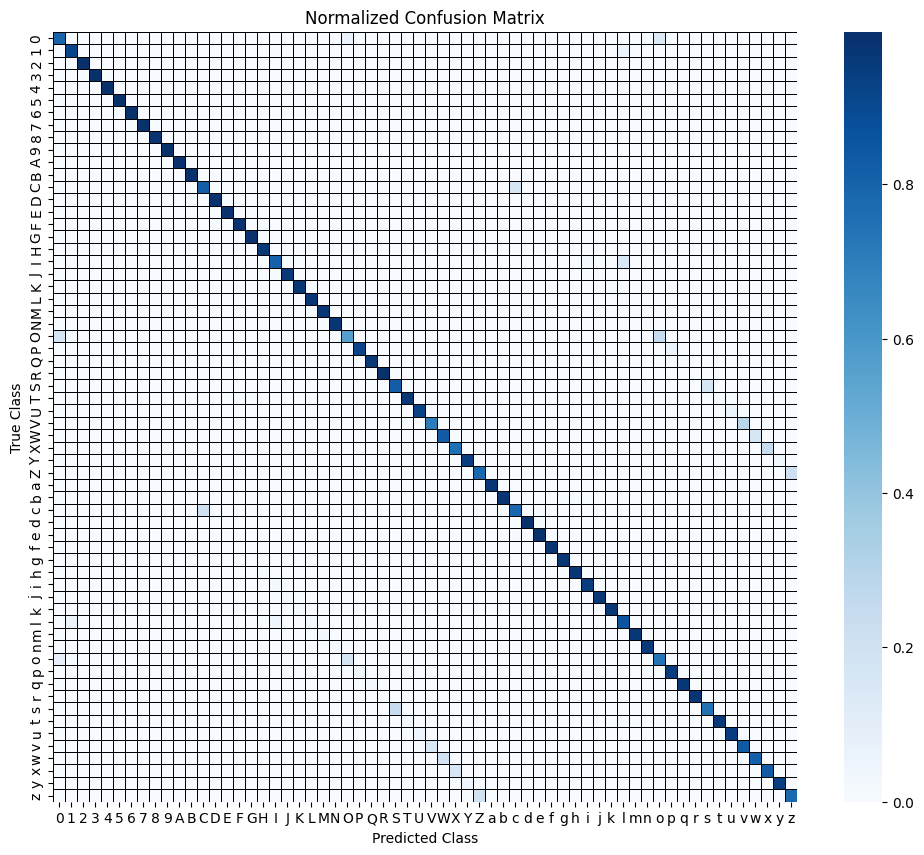

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import string

class_labels = list(string.digits) + list(string.ascii_uppercase) + list(string.ascii_lowercase)

# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Normalize the confusion matrix for better interpretability
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, fmt=".2f", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, linewidths=0.5, linecolor='black')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.show()

# Training

In [16]:
# Uncomment to use the previously calculated optimal epochs
# average_optimal_epochs = 17

In [17]:
final_model = keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    
    # First Convolutional Layer
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer
    layers.Conv2D(192, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output to feed into Dense layers
    layers.Flatten(),

    # Fully Connected Layer with Dropout
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),

    # Output Layer with Softmax activation for multi-class classification
    layers.Dense(62, activation='softmax')
])

# Compile the model
final_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Train the model
final_model.fit(X, y,
                epochs=average_optimal_epochs,
                batch_size=96,
                verbose=1)

Epoch 1/17
554/554 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5854 - loss: 1.5844
Epoch 2/17
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8553 - loss: 0.4041
Epoch 3/17
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8812 - loss: 0.3075
Epoch 4/17
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9030 - loss: 0.2425
Epoch 5/17
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9102 - loss: 0.2187
Epoch 6/17
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9173 - loss: 0.2029
Epoch 7/17
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9235 - loss: 0.1847
Epoch 8/17
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9324 - loss: 0.1625
Epoch 9/17
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9376 - loss: 0.1552
Epoch 10/17
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9407 - loss: 0.1454
Epoch 11/17
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9447 - loss: 0.1357
Epoch 12/17
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

# Prediction

In [18]:
test_folder_path = 'data/test'

In [19]:
test_images = []
test_labels = []


test_files = os.listdir(test_folder_path)
test_files_sorted = sorted(test_files)
num_test_files = len(dir)

for i, image_file in enumerate(test_files_sorted):
    if((i + 1) % 100 == 0):
        print(f"{i + 1}/{num_test_files}")

    image_path = os.path.join(test_folder_path, image_file)

    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image to 28x28
    img = cv2.resize(img, (28, 28))

    # Append image and label to the lists
    test_images.append(img)
    test_labels.append(image_file)

# Convert lists to numpy arrays
test_images = np.array(test_images)

# Reshape the images to add a channel dimension (for grayscale images)
test_images = test_images.reshape(-1, 28, 28, 1)

# Normalize pixel values to the range [0, 1]
test_images = test_images / 255.0


100/62
200/62
300/62
400/62
500/62
600/62
700/62
800/62
900/62
1000/62
1100/62
1200/62
1300/62
1400/62
1500/62
1600/62
1700/62
1800/62
1900/62
2000/62
2100/62
2200/62
2300/62
2400/62
2500/62
2600/62
2700/62
2800/62
2900/62
3000/62
3100/62
3200/62
3300/62
3400/62
3500/62
3600/62
3700/62
3800/62
3900/62
4000/62
4100/62
4200/62
4300/62
4400/62
4500/62
4600/62
4700/62
4800/62
4900/62
5000/62
5100/62
5200/62
5300/62
5400/62
5500/62
5600/62
5700/62
5800/62
5900/62
6000/62
6100/62
6200/62
6300/62
6400/62
6500/62
6600/62
6700/62
6800/62
6900/62
7000/62
7100/62


In [20]:
test_pred = final_model.predict(test_images)

222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [21]:
test_pred.shape

(7100, 62)

In [22]:
# Write out prediction values
with open('prediction.csv', 'w') as f:
    f.write("class;TestImage\n")
    for i in range(len(test_images)):
        
        predicted_class = np.argmax(test_pred[i]) + 1
        label = test_labels[i]
        
        f.write(f"{predicted_class};{label}\n")

print("Predictions saved to 'prediction.csv'")

Predictions saved to 'prediction.csv'
